In [1]:
!pip install -U tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 9.3 MB/s eta 0:00:00


In [2]:
from tensorflow.keras import layers
import tensorflow_addons as tfa
from tensorflow import keras
import tensorflow as tf

import matplotlib.pyplot as plt
import numpy as np
import random

import cv2
import numpy as np
from keras.utils import to_categorical
import os
import pandas as pd

# Setting seeds for reproducibility.
SEED = 11
keras.utils.set_random_seed(SEED)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


**Mounted Drive**

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip /content/drive/MyDrive/project2VDT/sourceCode/data.zip -d /

**Construct data**

In [5]:
INPUT_PATH = '/content/data'
EMOTIONS = ["happy","sad"]
IMAGE_SIZE = (96, 96)

def image_generator(input_path, emotions, image_size):
    for index, emotion in enumerate(emotions):
        for filename in os.listdir(os.path.join(input_path, emotion)):
            img = cv2.imread(os.path.join(input_path, emotion, filename))
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
            img = cv2.resize(img, image_size)
            #img = img.astype('float32') / 255.0  # Normilize
            yield img, index

def load_images(input_path, emotions, image_size):
    X, y = [], []
    for img, label in image_generator(input_path, emotions, image_size):
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

In [6]:
X, y = load_images(INPUT_PATH,EMOTIONS, IMAGE_SIZE)
input_shape = X[0].shape

**dataset for classification**

In [7]:
id_pos = np.where(y == 1)[0]
id_neg = np.where(y == 0)[0]

np.random.shuffle(id_pos)
np.random.shuffle(id_neg)

id_train_neg = id_neg[:int(len(id_neg) * 0.7)]
id_train_pos = id_pos[:int(len(id_pos) * 0.7)]
id_train = np.concatenate((id_train_neg, id_train_pos), axis = 0)

id_val_neg = id_neg[int(len(id_neg) * 0.7):int(len(id_neg) * 0.9)]
id_val_pos = id_pos[int(len(id_pos) * 0.7):int(len(id_pos) * 0.9)]
id_val = np.concatenate((id_val_neg, id_val_pos), axis = 0)

id_test_neg = id_neg[int(len(id_neg) * 0.9):]
id_test_pos = id_pos[int(len(id_pos) * 0.9):]
id_test = np.concatenate((id_test_neg, id_test_pos), axis = 0)

In [8]:
#train
x_train = X[id_train]
y_train = y[id_train]
#val
x_val = X[id_val]
y_val = y[id_val]
#test
x_test = X[id_test]
y_test = y[id_test]

y_train = y_train.reshape((-1, 1))
y_val = y_val.reshape((-1, 1))
y_test = y_test.reshape((-1, 1))
y_train = to_categorical(y_train,dtype = 'int32')
y_val = to_categorical(y_val,dtype = 'int32')
y_test = to_categorical(y_test,dtype = 'int32')

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_val shape: {x_val.shape} - y_val shape: {y_val.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (8272, 96, 96, 3) - y_train shape: (8272, 2)
x_val shape: (2363, 96, 96, 3) - y_val shape: (2363, 2)
x_test shape: (1183, 96, 96, 3) - y_test shape: (1183, 2)


**HyperParameter Setup**

In [9]:
# DATA
BUFFER_SIZE = 1024
BATCH_SIZE = 256
AUTO = tf.data.AUTOTUNE
INPUT_SHAPE = input_shape
NUM_CLASSES = 2

# OPTIMIZER
LEARNING_RATE = 5e-3
WEIGHT_DECAY = 1e-4

# PRETRAINING
EPOCHS = 100

# AUGMENTATION
IMAGE_SIZE = 96  # We will resize input images to this size.
PATCH_SIZE = 6  # Size of the patches to be extracted from the input images.
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
MASK_PROPORTION = 0.5  # We have found 50% masking to give us the best results.

# ENCODER and DECODER
LAYER_NORM_EPS = 1e-6
ENC_PROJECTION_DIM = 128
DEC_PROJECTION_DIM = 64
ENC_NUM_HEADS = 4
ENC_LAYERS = 6
DEC_NUM_HEADS = 4
DEC_LAYERS = (
    2  # The decoder is lightweight but should be reasonably deep for reconstruction.
)
ENC_TRANSFORMER_UNITS = [
    ENC_PROJECTION_DIM * 2,
    ENC_PROJECTION_DIM,
]  # Size of the transformer layers.
DEC_TRANSFORMER_UNITS = [
    DEC_PROJECTION_DIM * 2,
    DEC_PROJECTION_DIM,
]

mlp_head_units = [2048, 1024]

SEED = 11 

**Util**

In [10]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Lambda, Dropout, LayerNormalization, MultiHeadAttention
from tensorflow.keras.activations import gelu
import numpy as np

#Patch image to subimage (adapt with input of visionTransformer)
class Patches(layers.Layer):
    def __init__(self,patch_size = PATCH_SIZE):
        super(Patches,self).__init__()
        self.patch_size = patch_size
        self.resize = layers.Reshape((-1, patch_size * patch_size * 3))
    
    def call(self, images):
        # print(images.shape)
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        # print(patches.shape)

        # Reshape the patches to (batch, num_patches, patch_area) and return it.
        patches = self.resize(patches)
        return patches

    def show_patched_image(self, images, patches):
        idx = np.random.choice(patches.shape[0])
        print(f"Index selected: {idx}.")

        plt.figure(figsize=(4, 4))
        plt.imshow(keras.utils.array_to_img(images[idx]))
        plt.axis("off")
        plt.show()

        n = int(np.sqrt(patches.shape[1]))
        plt.figure(figsize=(4, 4))
        for i, patch in enumerate(patches[idx]):
            ax = plt.subplot(n, n, i + 1)
            patch_img = tf.reshape(patch, (self.patch_size, self.patch_size, 3))
            plt.imshow(keras.utils.img_to_array(patch_img))
            plt.axis("off")
        plt.show()

        # Return the index chosen to validate it outside the method.
        return idx

    def reconstruct_from_patch(self, patch):
        num_patches = patch.shape[0]
        n = int(np.sqrt(num_patches))
        patch = tf.reshape(patch, (num_patches, self.patch_size, self.patch_size, 3))
        rows = tf.split(patch, n, axis=0)
        rows = [tf.concat(tf.unstack(x), axis=1) for x in rows]
        reconstructed = tf.concat(rows, axis=0)
        return reconstructed

def get_angle(pos, i, d_model):
    indices = i // 2
    angle_rates = 1 / np.power(10000,(2*indices) / np.float32(d_model))
    
    return pos * angle_rates
    
def pos_encoding(pos,d_model):
    angle_rads = get_angle(np.arange(pos)[:,np.newaxis],
                            np.arange(d_model)[np.newaxis,:],
                            d_model)
    
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

class PatchEncoder(layers.Layer):
    def __init__(self, patch_size=PATCH_SIZE, projection_dim=ENC_PROJECTION_DIM, mask_proportion = MASK_PROPORTION, downstream = False):
        super(PatchEncoder,self).__init__()
        self.patch_size = patch_size
        self.projection_dim = projection_dim
        self.mask_proportion = mask_proportion
        self.mask_token = tf.Variable(
            tf.random.normal([1, patch_size * patch_size * 3]), trainable=True
        )
        self.downstream = downstream

    def build(self, input_shape):
        (_,self.num_patches, self.patch_area) = input_shape
        self.projection = layers.Dense(units=self.projection_dim)
        self.position_embedding = pos_encoding(pos = self.num_patches, d_model = self.projection_dim)
        self.num_mask = int(self.mask_proportion * self.num_patches)

    def call(self, patches):
        batch_size = tf.shape(patches)[0]
        position_embedding = self.position_embedding
        # print("phase0: ",self.position_embedding.shape)
        position_embedding = tf.tile(
            position_embedding, [batch_size, 1, 1]
        )  # (B, num_patches, projection_dim)
        # print("phase1: ",self.position_embedding.shape)
        # print("phase2: ",self.projection(patches).shape)
        patch_embeddings = (self.projection(patches) + position_embedding)
        if self.downstream:
            return patch_embeddings
        else:
            mask_indices, unmask_indices = self.get_random_indices(batch_size)
            unmasked_embeddings = tf.gather(
                patch_embeddings, unmask_indices, axis=1, batch_dims=1
            )
            unmasked_positions = tf.gather(
                position_embedding, unmask_indices, axis=1, batch_dims=1
            )  # (B, unmask_numbers, projection_dim)

            masked_positions = tf.gather(
                position_embedding, mask_indices, axis=1, batch_dims=1
            )  # (B, mask_numbers, projection_dim)        

            mask_tokens = tf.repeat(self.mask_token, repeats=self.num_mask, axis=0)
            mask_tokens = tf.repeat(
                mask_tokens[tf.newaxis, ...], repeats=batch_size, axis=0
            )

            masked_embeddings = self.projection(mask_tokens) + masked_positions
            return (
                unmasked_embeddings,  # Input to the encoder.
                masked_embeddings,  # First part of input to the decoder.
                unmasked_positions,  # Added to the encoder outputs.
                mask_indices,  # The indices that were masked.
                unmask_indices,  # The indices that were unmaksed.
            )
    
    def get_random_indices(self, batch_size):
        # Create random indices from a uniform distribution and then split
        # it into mask and unmask indices.
        rand_indices = tf.argsort(
            tf.random.uniform(shape=(batch_size, self.num_patches)), axis=-1
        )
        mask_indices = rand_indices[:, : self.num_mask]
        unmask_indices = rand_indices[:, self.num_mask :]
        return mask_indices, unmask_indices

    def generate_masked_image(self, patches, unmask_indices):
        # Choose a random patch and it corresponding unmask index.
        idx = np.random.choice(patches.shape[0])
        patch = patches[idx]
        unmask_index = unmask_indices[idx]

        # Build a numpy array of same shape as patch.
        new_patch = np.zeros_like(patch)

        # Iterate of the new_patch and plug the unmasked patches.
        count = 0
        for i in range(unmask_index.shape[0]):
            new_patch[unmask_index[i]] = patch[unmask_index[i]]
        return new_patch, idx

class TransformerBlock(layers.Layer):
    def __init__(self, num_heads, mlp_dim, dropout):
        super(TransformerBlock,self).__init__()
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout

    def build(self, input_shape):
        self.att = MultiHeadAttention(
            num_heads = self.num_heads,
            key_dim = input_shape[-1] // self.num_heads #d_model is input_shape[-1]
        )
        
        self.mlpBlock = Sequential([
            Dense(self.mlp_dim[0],activation=tf.nn.gelu),
            Dropout(self.dropout),
            Dense(self.mlp_dim[1],activation=tf.nn.gelu),
            Dropout(self.dropout),
        ])

        self.layerNorm1 = LayerNormalization(epsilon = LAYER_NORM_EPS)
        self.layerNorm2 = LayerNormalization(epsilon = LAYER_NORM_EPS)
        self.layerDropout = Dropout(self.dropout)
    
    def call(self, inputs, training):
        x = self.att(inputs,inputs)
        x = self.layerDropout(x, training = training)
        x = x + inputs
        y = self.layerNorm2(x)
        y = self.mlpBlock(y)
        x = x + y
        x = self.layerNorm1(x)
        return x

def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units = units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def Encoder(num_heads = ENC_NUM_HEADS, num_layers = ENC_LAYERS):
    inputs = layers.Input((None, ENC_PROJECTION_DIM))
    x = inputs

    for _ in range(num_layers):
        x = TransformerBlock(num_heads,ENC_TRANSFORMER_UNITS,0.1)(x)
    outputs = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    return keras.Model(inputs, outputs, name="mae_encoder")

def Decoder(num_layers=DEC_LAYERS, num_heads=DEC_NUM_HEADS, image_size=IMAGE_SIZE):
    inputs = layers.Input((NUM_PATCHES, ENC_PROJECTION_DIM))
    x = layers.Dense(DEC_PROJECTION_DIM)(inputs)

    for _ in range(num_layers):
        x = TransformerBlock(num_heads,DEC_TRANSFORMER_UNITS,0.1)(x)
    x = layers.LayerNormalization(epsilon=LAYER_NORM_EPS)(x)
    x = layers.Flatten()(x)
    pre_final = layers.Dense(units=image_size * image_size * 3, activation="sigmoid")(x)
    outputs = layers.Reshape((image_size, image_size, 3))(pre_final)
    return keras.Model(inputs=inputs, outputs=outputs,name="mae_decoder")

**Augmentation for autoencoder task**

In [11]:
def get_train_augmentation_model():
    model = keras.Sequential(
        [
            layers.Rescaling(1 / 255.0),
            layers.RandomCrop(92, 92, seed=SEED, input_shape=input_shape),
            layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
            layers.RandomFlip("horizontal", seed=SEED),
            layers.RandomRotation(0.2, seed=SEED),
        ],
        name="train_data_augmentation",
    )
    return model


def get_test_augmentation_model():
    model = keras.Sequential(
        [layers.Rescaling(1 / 255.0), layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),],
        name="test_data_augmentation",
    )
    return model

In [12]:
train_ds = tf.data.Dataset.from_tensor_slices(x_train)
train_ds = train_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(AUTO)

val_ds = tf.data.Dataset.from_tensor_slices(x_val)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(AUTO)

test_ds = tf.data.Dataset.from_tensor_slices(x_test)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(AUTO)

**Model**

In [13]:
class MaskedAutoencoder(keras.Model):
    def __init__(
        self,
        train_augmentation_model,
        test_augmentation_model,
        patch_layer,
        patch_encoder,
        encoder,
        decoder,
    ):
        super(MaskedAutoencoder,self).__init__()
        self.train_augmentation_model = train_augmentation_model
        self.test_augmentation_model = test_augmentation_model
        self.patch_layer = patch_layer
        self.patch_encoder = patch_encoder
        self.encoder = encoder
        self.decoder = decoder

    def calculate_loss(self, images, test=False):
        if test:
            augmented_images = self.test_augmentation_model(images)
        else:
            augmented_images = self.train_augmentation_model(images)

        patches = self.patch_layer(augmented_images)
        (
            unmasked_embeddings,
            masked_embeddings,
            unmasked_positions,
            mask_indices,
            unmask_indices,
        ) = self.patch_encoder(patches)

        encoder_outputs = self.encoder(unmasked_embeddings)
        encoder_outputs = encoder_outputs + unmasked_positions
        decoder_inputs = tf.concat([encoder_outputs, masked_embeddings], axis=1)

        decoder_outputs = self.decoder(decoder_inputs)
        decoder_patches = self.patch_layer(decoder_outputs)

        loss_patch = tf.gather(patches, mask_indices, axis=1, batch_dims=1)
        loss_output = tf.gather(decoder_patches, mask_indices, axis=1, batch_dims=1)

        total_loss = self.compiled_loss(loss_patch, loss_output)
        return total_loss, loss_patch, loss_output

    def train_step(self, images):
        with tf.GradientTape() as tape:
            total_loss, loss_patch, loss_output = self.calculate_loss(images)

        # Apply gradients.
        train_vars = [
            self.train_augmentation_model.trainable_variables,
            self.patch_layer.trainable_variables,
            self.patch_encoder.trainable_variables,
            self.encoder.trainable_variables,
            self.decoder.trainable_variables,
        ]
        grads = tape.gradient(total_loss, train_vars)
        tv_list = []
        for (grad, var) in zip(grads, train_vars):
            for g, v in zip(grad, var):
                tv_list.append((g, v))
        self.optimizer.apply_gradients(tv_list)

        # Report progress.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

    def test_step(self, images):
        total_loss, loss_patch, loss_output = self.calculate_loss(images, test=True)

        # Update the trackers.
        self.compiled_metrics.update_state(loss_patch, loss_output)
        return {m.name: m.result() for m in self.metrics}

In [14]:
# Taking a batch of test inputs to measure model's progress.
test_images = next(iter(test_ds))


class TrainMonitor(keras.callbacks.Callback):
    def __init__(self, epoch_interval=None):
        self.epoch_interval = epoch_interval

    def on_epoch_end(self, epoch, logs=None):
        if self.epoch_interval and epoch % self.epoch_interval == 0:
            test_augmented_images = self.model.test_augmentation_model(test_images)
            test_patches = self.model.patch_layer(test_augmented_images)
            (
                test_unmasked_embeddings,
                test_masked_embeddings,
                test_unmasked_positions,
                test_mask_indices,
                test_unmask_indices,
            ) = self.model.patch_encoder(test_patches)
            test_encoder_outputs = self.model.encoder(test_unmasked_embeddings)
            test_encoder_outputs = test_encoder_outputs + test_unmasked_positions
            test_decoder_inputs = tf.concat(
                [test_encoder_outputs, test_masked_embeddings], axis=1
            )
            test_decoder_outputs = self.model.decoder(test_decoder_inputs)

            # Show a maksed patch image.
            test_masked_patch, idx = self.model.patch_encoder.generate_masked_image(
                test_patches, test_unmask_indices
            )
            print(f"\nIdx chosen: {idx}")
            original_image = test_augmented_images[idx]
            masked_image = self.model.patch_layer.reconstruct_from_patch(
                test_masked_patch
            )
            reconstructed_image = test_decoder_outputs[idx]

            fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
            ax[0].imshow(original_image)
            ax[0].set_title(f"Original: {epoch:03d}")

            ax[1].imshow(masked_image)
            ax[1].set_title(f"Masked: {epoch:03d}")

            ax[2].imshow(reconstructed_image)
            ax[2].set_title(f"Resonstructed: {epoch:03d}")

            plt.show()
            plt.close()

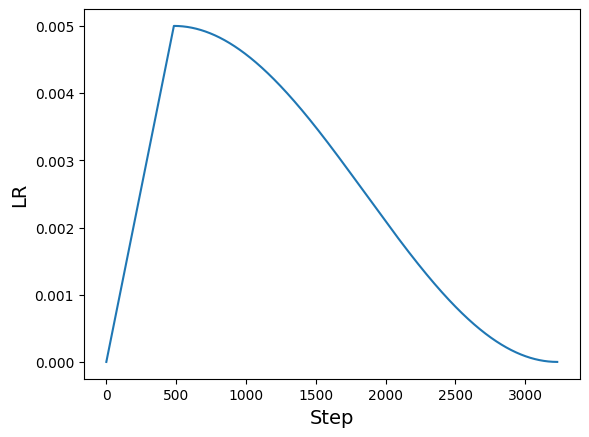

In [15]:
class WarmUpCosine(keras.optimizers.schedules.LearningRateSchedule):
    def __init__(
        self, learning_rate_base, total_steps, warmup_learning_rate, warmup_steps
    ):
        super().__init__()

        self.learning_rate_base = learning_rate_base
        self.total_steps = total_steps
        self.warmup_learning_rate = warmup_learning_rate
        self.warmup_steps = warmup_steps
        self.pi = tf.constant(np.pi)

    def __call__(self, step):
        if self.total_steps < self.warmup_steps:
            raise ValueError("Total_steps must be larger or equal to warmup_steps.")

        cos_annealed_lr = tf.cos(
            self.pi
            * (tf.cast(step, tf.float32) - self.warmup_steps)
            / float(self.total_steps - self.warmup_steps)
        )
        learning_rate = 0.5 * self.learning_rate_base * (1 + cos_annealed_lr)

        if self.warmup_steps > 0:
            if self.learning_rate_base < self.warmup_learning_rate:
                raise ValueError(
                    "Learning_rate_base must be larger or equal to "
                    "warmup_learning_rate."
                )
            slope = (
                self.learning_rate_base - self.warmup_learning_rate
            ) / self.warmup_steps
            warmup_rate = slope * tf.cast(step, tf.float32) + self.warmup_learning_rate
            learning_rate = tf.where(
                step < self.warmup_steps, warmup_rate, learning_rate
            )
        return tf.where(
            step > self.total_steps, 0.0, learning_rate, name="learning_rate"
        )


total_steps = int((len(x_train) / BATCH_SIZE) * EPOCHS)
warmup_epoch_percentage = 0.15
warmup_steps = int(total_steps * warmup_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=LEARNING_RATE,
    total_steps=total_steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

lrs = [scheduled_lrs(step) for step in range(total_steps)]
plt.plot(lrs)
plt.xlabel("Step", fontsize=14)
plt.ylabel("LR", fontsize=14)
plt.show()

# Assemble the callbacks.
train_callbacks = [TrainMonitor(epoch_interval=5)]

**Compile and training**

In [16]:
train_augmentation_model = get_train_augmentation_model()
test_augmentation_model = get_test_augmentation_model()
patch_layer = Patches()
patch_encoder = PatchEncoder()
encoder = Encoder()
decoder = Decoder()

mae_model = MaskedAutoencoder(
    train_augmentation_model=train_augmentation_model,
    test_augmentation_model=test_augmentation_model,
    patch_layer=patch_layer,
    patch_encoder=patch_encoder,
    encoder=encoder,
    decoder=decoder,
)

Epoch 1/100
33/33 [==============================] - ETA: 0s - loss: 0.0747 - mae: 0.2205
Idx chosen: 234


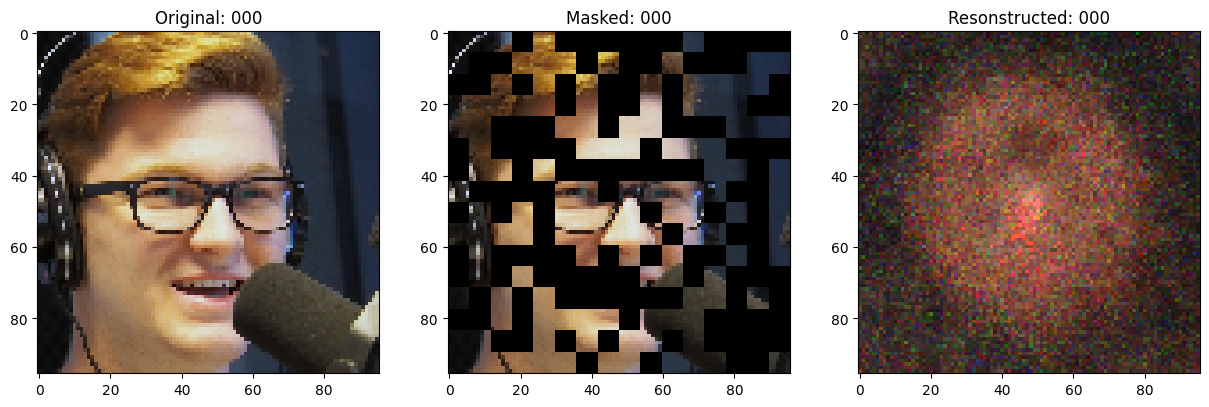

33/33 [==============================] - 49s 766ms/step - loss: 0.0747 - mae: 0.2205 - val_loss: 0.0663 - val_mae: 0.2013
Epoch 2/100
33/33 [==============================] - 23s 692ms/step - loss: 0.0524 - mae: 0.1838 - val_loss: 0.0588 - val_mae: 0.1950
Epoch 3/100
33/33 [==============================] - 23s 708ms/step - loss: 0.0523 - mae: 0.1837 - val_loss: 0.0586 - val_mae: 0.1955
Epoch 4/100
33/33 [==============================] - 24s 742ms/step - loss: 0.0520 - mae: 0.1832 - val_loss: 0.0572 - val_mae: 0.1936
Epoch 5/100
33/33 [==============================] - 23s 710ms/step - loss: 0.0516 - mae: 0.1822 - val_loss: 0.0579 - val_mae: 0.1935
Epoch 6/100
33/33 [==============================] - ETA: 0s - loss: 0.0476 - mae: 0.1754
Idx chosen: 228


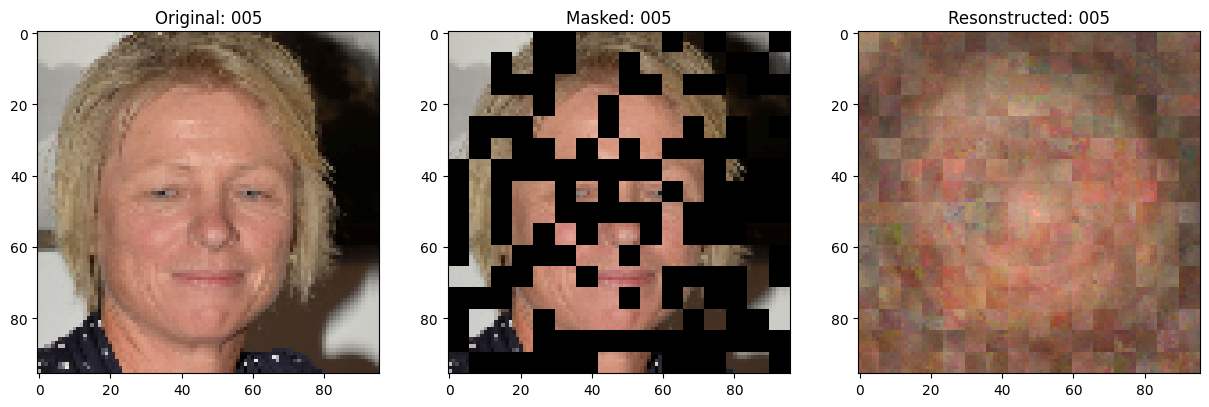

33/33 [==============================] - 24s 736ms/step - loss: 0.0476 - mae: 0.1754 - val_loss: 0.0515 - val_mae: 0.1804
Epoch 7/100
33/33 [==============================] - 23s 710ms/step - loss: 0.0443 - mae: 0.1678 - val_loss: 0.0511 - val_mae: 0.1793
Epoch 8/100
33/33 [==============================] - 24s 724ms/step - loss: 0.0426 - mae: 0.1641 - val_loss: 0.0466 - val_mae: 0.1728
Epoch 9/100
33/33 [==============================] - 23s 712ms/step - loss: 0.0383 - mae: 0.1547 - val_loss: 0.0434 - val_mae: 0.1653
Epoch 10/100
33/33 [==============================] - 23s 709ms/step - loss: 0.0361 - mae: 0.1490 - val_loss: 0.0426 - val_mae: 0.1618
Epoch 11/100
33/33 [==============================] - ETA: 0s - loss: 0.0342 - mae: 0.1443
Idx chosen: 115


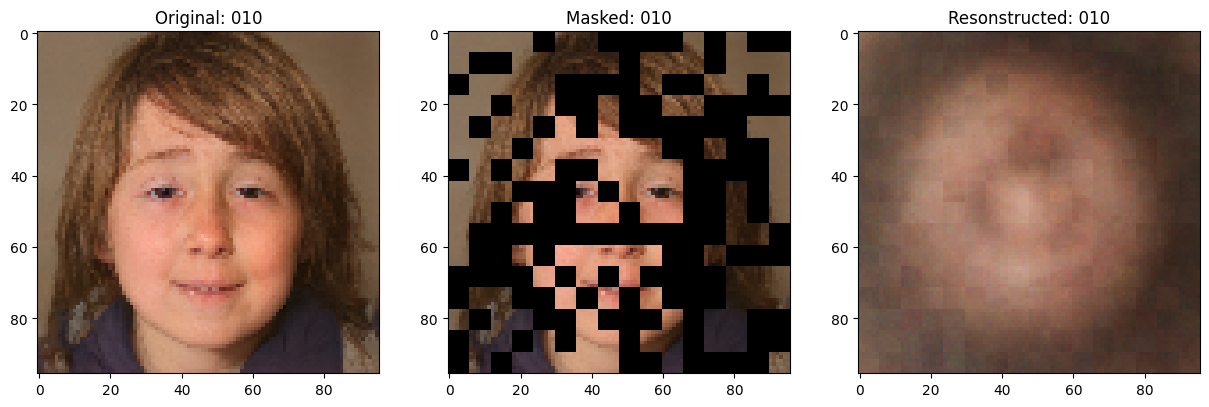

33/33 [==============================] - 25s 759ms/step - loss: 0.0342 - mae: 0.1443 - val_loss: 0.0386 - val_mae: 0.1527
Epoch 12/100
33/33 [==============================] - 24s 736ms/step - loss: 0.0298 - mae: 0.1334 - val_loss: 0.0337 - val_mae: 0.1400
Epoch 13/100
33/33 [==============================] - 24s 723ms/step - loss: 0.0270 - mae: 0.1260 - val_loss: 0.0319 - val_mae: 0.1361
Epoch 14/100
33/33 [==============================] - 24s 732ms/step - loss: 0.0248 - mae: 0.1198 - val_loss: 0.0295 - val_mae: 0.1323
Epoch 15/100
33/33 [==============================] - 24s 723ms/step - loss: 0.0234 - mae: 0.1160 - val_loss: 0.0275 - val_mae: 0.1247
Epoch 16/100
33/33 [==============================] - ETA: 0s - loss: 0.0219 - mae: 0.1114
Idx chosen: 43


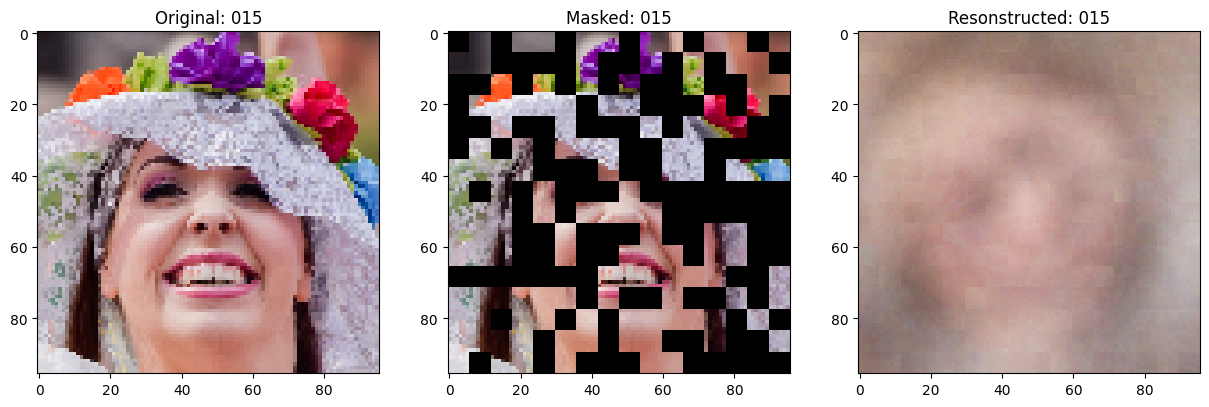

33/33 [==============================] - 25s 770ms/step - loss: 0.0219 - mae: 0.1114 - val_loss: 0.0276 - val_mae: 0.1247
Epoch 17/100
33/33 [==============================] - 24s 739ms/step - loss: 0.0211 - mae: 0.1090 - val_loss: 0.0251 - val_mae: 0.1187
Epoch 18/100
33/33 [==============================] - 24s 738ms/step - loss: 0.0200 - mae: 0.1059 - val_loss: 0.0243 - val_mae: 0.1159
Epoch 19/100
33/33 [==============================] - 24s 736ms/step - loss: 0.0192 - mae: 0.1031 - val_loss: 0.0240 - val_mae: 0.1156
Epoch 20/100
33/33 [==============================] - 24s 740ms/step - loss: 0.0186 - mae: 0.1012 - val_loss: 0.0231 - val_mae: 0.1125
Epoch 21/100
33/33 [==============================] - ETA: 0s - loss: 0.0180 - mae: 0.0995
Idx chosen: 51


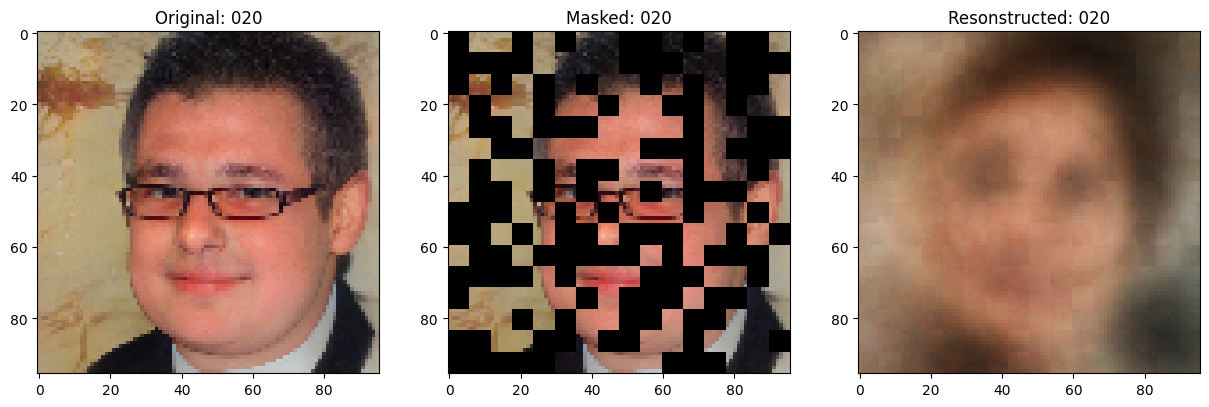

33/33 [==============================] - 25s 754ms/step - loss: 0.0180 - mae: 0.0995 - val_loss: 0.0234 - val_mae: 0.1129
Epoch 22/100
33/33 [==============================] - 23s 711ms/step - loss: 0.0176 - mae: 0.0981 - val_loss: 0.0215 - val_mae: 0.1068
Epoch 23/100
33/33 [==============================] - 23s 713ms/step - loss: 0.0172 - mae: 0.0968 - val_loss: 0.0216 - val_mae: 0.1074
Epoch 24/100
33/33 [==============================] - 24s 725ms/step - loss: 0.0167 - mae: 0.0950 - val_loss: 0.0210 - val_mae: 0.1053
Epoch 25/100
33/33 [==============================] - 23s 709ms/step - loss: 0.0162 - mae: 0.0935 - val_loss: 0.0205 - val_mae: 0.1046
Epoch 26/100
33/33 [==============================] - ETA: 0s - loss: 0.0160 - mae: 0.0927
Idx chosen: 166


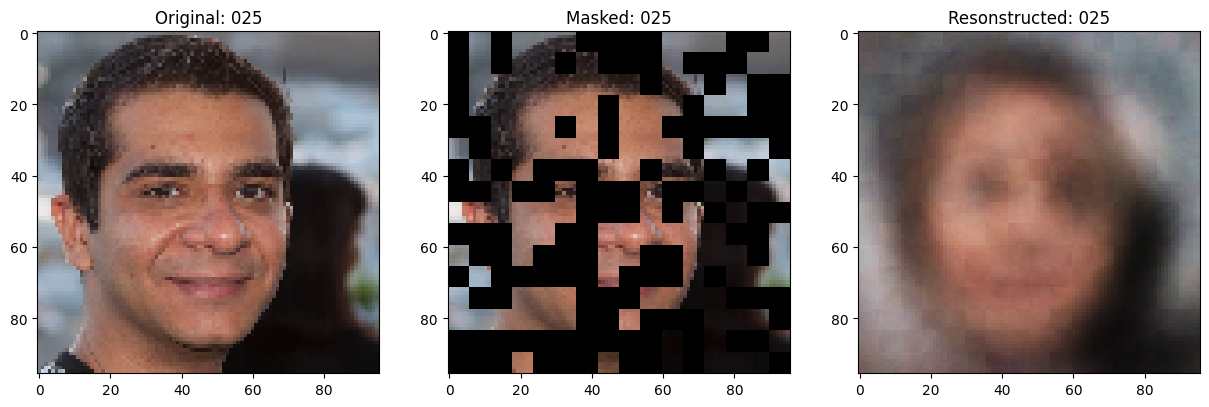

33/33 [==============================] - 25s 764ms/step - loss: 0.0160 - mae: 0.0927 - val_loss: 0.0201 - val_mae: 0.1031
Epoch 27/100
33/33 [==============================] - 24s 731ms/step - loss: 0.0157 - mae: 0.0918 - val_loss: 0.0198 - val_mae: 0.1021
Epoch 28/100
33/33 [==============================] - 24s 718ms/step - loss: 0.0154 - mae: 0.0909 - val_loss: 0.0194 - val_mae: 0.1009
Epoch 29/100
33/33 [==============================] - 24s 719ms/step - loss: 0.0152 - mae: 0.0902 - val_loss: 0.0204 - val_mae: 0.1042
Epoch 30/100
33/33 [==============================] - 23s 710ms/step - loss: 0.0151 - mae: 0.0899 - val_loss: 0.0189 - val_mae: 0.0988
Epoch 31/100
33/33 [==============================] - ETA: 0s - loss: 0.0146 - mae: 0.0880
Idx chosen: 98


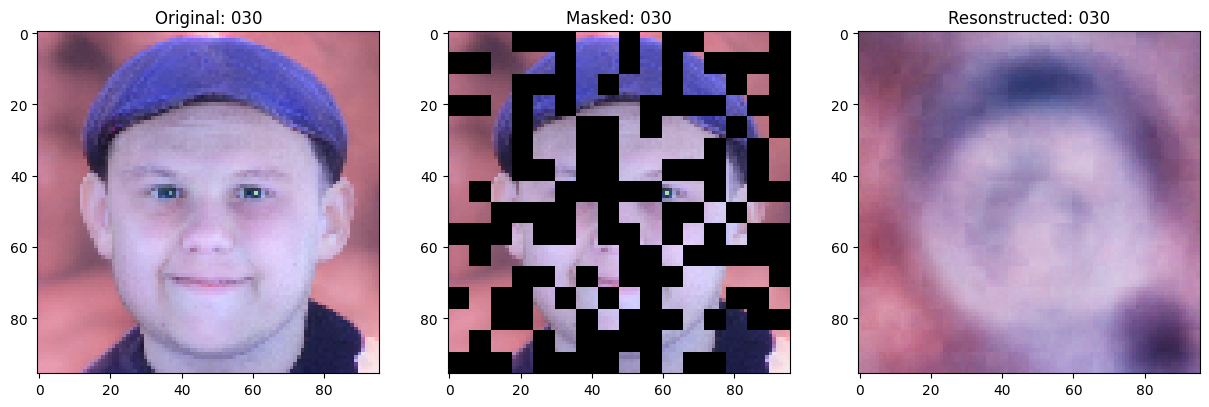

33/33 [==============================] - 25s 767ms/step - loss: 0.0146 - mae: 0.0880 - val_loss: 0.0186 - val_mae: 0.0982
Epoch 32/100
33/33 [==============================] - 24s 735ms/step - loss: 0.0145 - mae: 0.0877 - val_loss: 0.0182 - val_mae: 0.0972
Epoch 33/100
33/33 [==============================] - 24s 719ms/step - loss: 0.0142 - mae: 0.0868 - val_loss: 0.0180 - val_mae: 0.0967
Epoch 34/100
33/33 [==============================] - 23s 710ms/step - loss: 0.0140 - mae: 0.0861 - val_loss: 0.0182 - val_mae: 0.0982
Epoch 35/100
33/33 [==============================] - 23s 712ms/step - loss: 0.0139 - mae: 0.0857 - val_loss: 0.0178 - val_mae: 0.0957
Epoch 36/100
33/33 [==============================] - ETA: 0s - loss: 0.0136 - mae: 0.0846
Idx chosen: 20


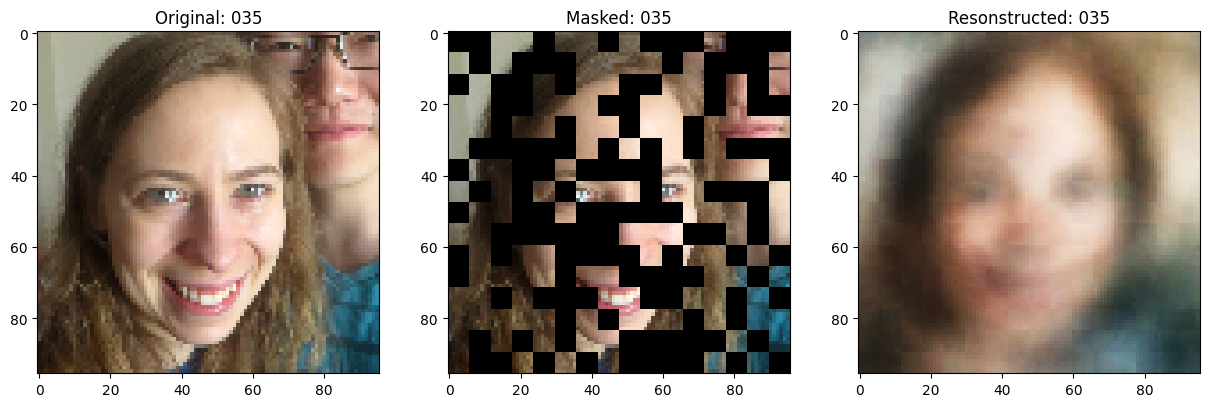

33/33 [==============================] - 25s 763ms/step - loss: 0.0136 - mae: 0.0846 - val_loss: 0.0177 - val_mae: 0.0955
Epoch 37/100
33/33 [==============================] - 23s 712ms/step - loss: 0.0134 - mae: 0.0841 - val_loss: 0.0173 - val_mae: 0.0937
Epoch 38/100
33/33 [==============================] - 24s 714ms/step - loss: 0.0133 - mae: 0.0835 - val_loss: 0.0176 - val_mae: 0.0961
Epoch 39/100
33/33 [==============================] - 24s 734ms/step - loss: 0.0131 - mae: 0.0831 - val_loss: 0.0174 - val_mae: 0.0942
Epoch 40/100
33/33 [==============================] - 25s 745ms/step - loss: 0.0130 - mae: 0.0827 - val_loss: 0.0170 - val_mae: 0.0939
Epoch 41/100
33/33 [==============================] - ETA: 0s - loss: 0.0128 - mae: 0.0817
Idx chosen: 195


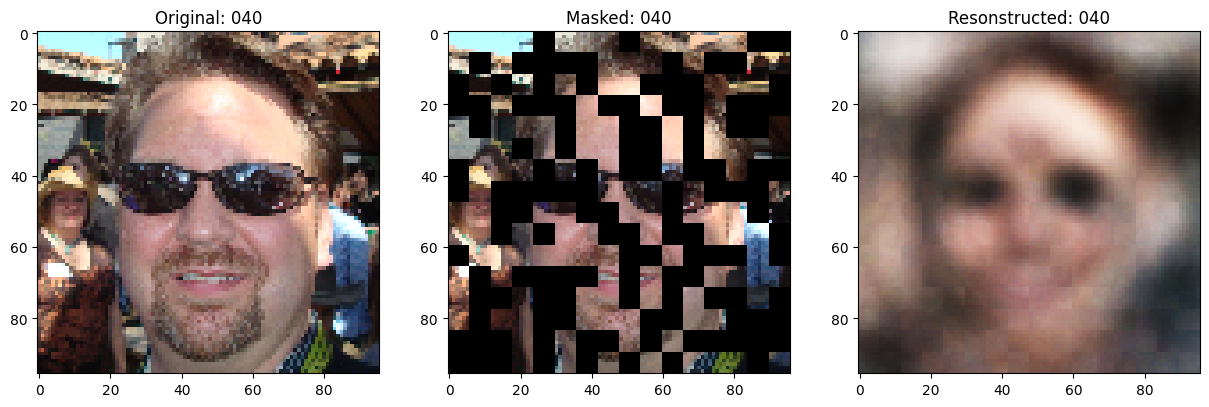

33/33 [==============================] - 24s 739ms/step - loss: 0.0128 - mae: 0.0817 - val_loss: 0.0167 - val_mae: 0.0921
Epoch 42/100
33/33 [==============================] - 24s 725ms/step - loss: 0.0126 - mae: 0.0809 - val_loss: 0.0165 - val_mae: 0.0918
Epoch 43/100
33/33 [==============================] - 23s 711ms/step - loss: 0.0125 - mae: 0.0807 - val_loss: 0.0169 - val_mae: 0.0923
Epoch 44/100
33/33 [==============================] - 24s 739ms/step - loss: 0.0125 - mae: 0.0807 - val_loss: 0.0163 - val_mae: 0.0905
Epoch 45/100
33/33 [==============================] - 24s 741ms/step - loss: 0.0121 - mae: 0.0794 - val_loss: 0.0161 - val_mae: 0.0903
Epoch 46/100
33/33 [==============================] - ETA: 0s - loss: 0.0121 - mae: 0.0792
Idx chosen: 175


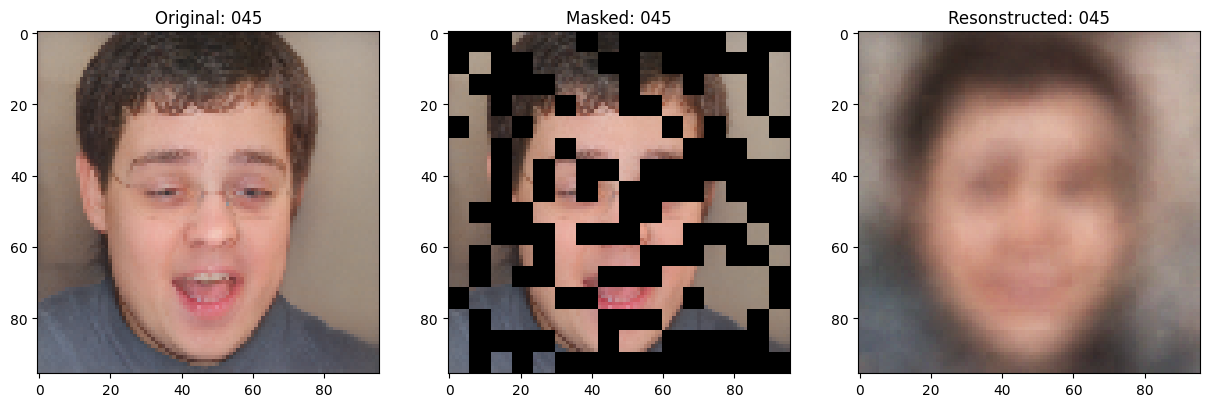

33/33 [==============================] - 25s 751ms/step - loss: 0.0121 - mae: 0.0792 - val_loss: 0.0161 - val_mae: 0.0903
Epoch 47/100
33/33 [==============================] - 23s 710ms/step - loss: 0.0120 - mae: 0.0787 - val_loss: 0.0160 - val_mae: 0.0898
Epoch 48/100
33/33 [==============================] - 23s 713ms/step - loss: 0.0119 - mae: 0.0784 - val_loss: 0.0158 - val_mae: 0.0889
Epoch 49/100
33/33 [==============================] - 23s 712ms/step - loss: 0.0118 - mae: 0.0779 - val_loss: 0.0159 - val_mae: 0.0886
Epoch 50/100
33/33 [==============================] - 24s 745ms/step - loss: 0.0117 - mae: 0.0774 - val_loss: 0.0158 - val_mae: 0.0893
Epoch 51/100
33/33 [==============================] - ETA: 0s - loss: 0.0116 - mae: 0.0771
Idx chosen: 160


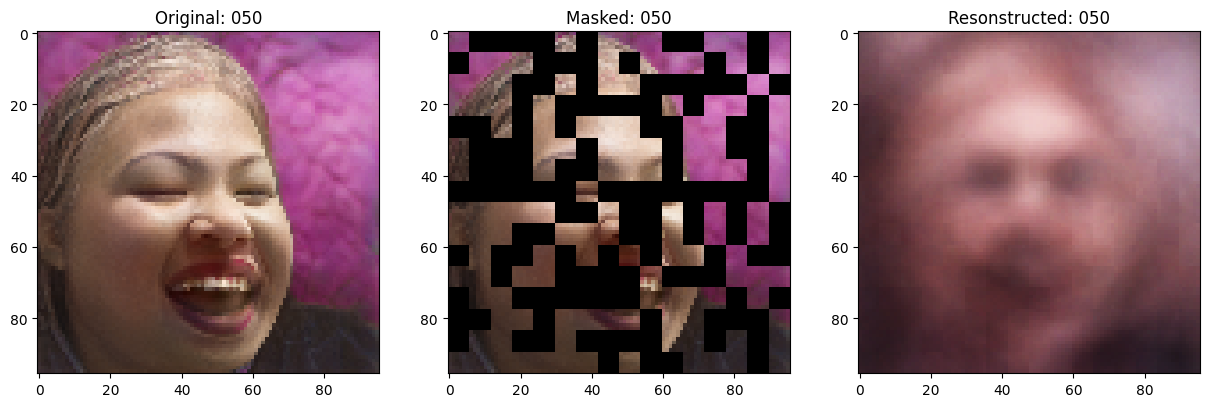

33/33 [==============================] - 25s 769ms/step - loss: 0.0116 - mae: 0.0771 - val_loss: 0.0157 - val_mae: 0.0879
Epoch 52/100
33/33 [==============================] - 24s 720ms/step - loss: 0.0115 - mae: 0.0769 - val_loss: 0.0155 - val_mae: 0.0878
Epoch 53/100
33/33 [==============================] - 23s 705ms/step - loss: 0.0114 - mae: 0.0764 - val_loss: 0.0153 - val_mae: 0.0873
Epoch 54/100
33/33 [==============================] - 24s 724ms/step - loss: 0.0113 - mae: 0.0759 - val_loss: 0.0155 - val_mae: 0.0875
Epoch 55/100
33/33 [==============================] - 24s 738ms/step - loss: 0.0113 - mae: 0.0758 - val_loss: 0.0153 - val_mae: 0.0873
Epoch 56/100
33/33 [==============================] - ETA: 0s - loss: 0.0112 - mae: 0.0755
Idx chosen: 12


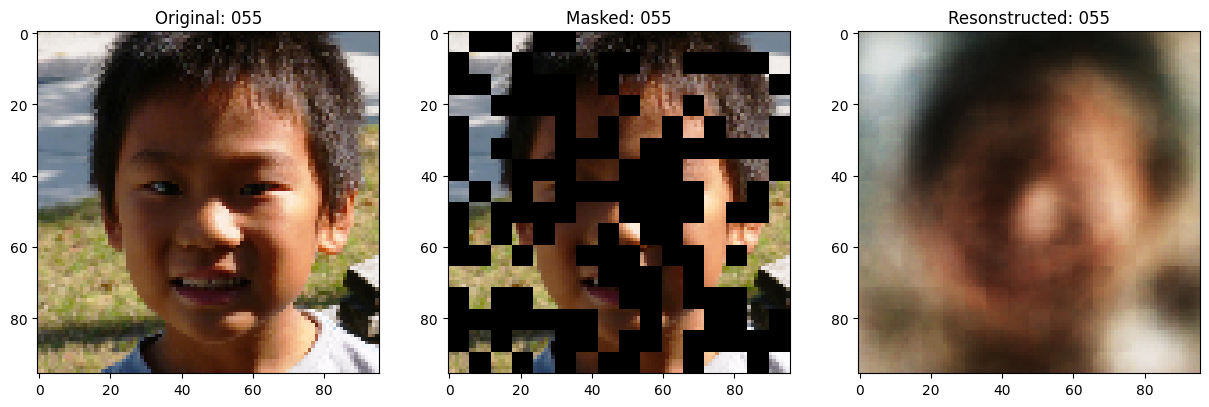

33/33 [==============================] - 24s 744ms/step - loss: 0.0112 - mae: 0.0755 - val_loss: 0.0154 - val_mae: 0.0881
Epoch 57/100
33/33 [==============================] - 24s 730ms/step - loss: 0.0111 - mae: 0.0753 - val_loss: 0.0151 - val_mae: 0.0866
Epoch 58/100
33/33 [==============================] - 24s 744ms/step - loss: 0.0110 - mae: 0.0747 - val_loss: 0.0150 - val_mae: 0.0862
Epoch 59/100
33/33 [==============================] - 24s 736ms/step - loss: 0.0110 - mae: 0.0748 - val_loss: 0.0150 - val_mae: 0.0860
Epoch 60/100
33/33 [==============================] - 24s 720ms/step - loss: 0.0109 - mae: 0.0744 - val_loss: 0.0149 - val_mae: 0.0857
Epoch 61/100
33/33 [==============================] - ETA: 0s - loss: 0.0109 - mae: 0.0741
Idx chosen: 101


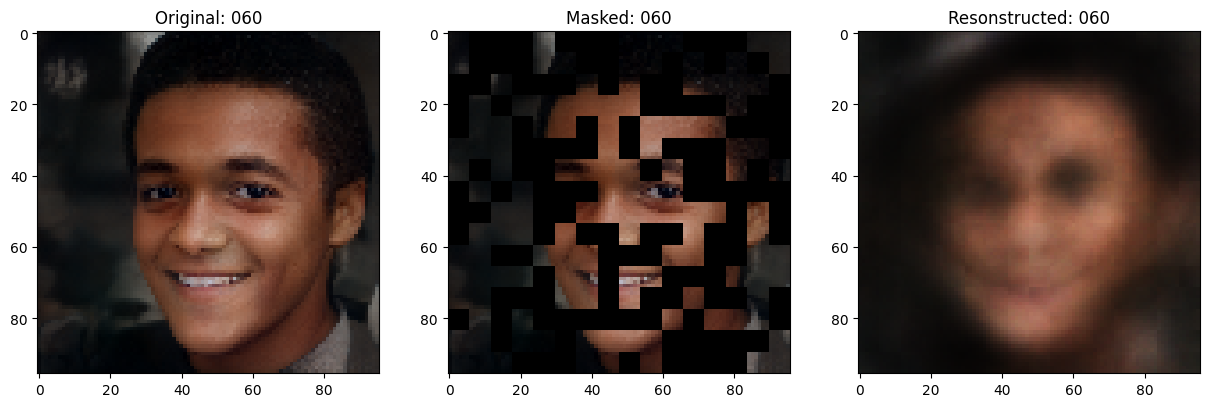

33/33 [==============================] - 25s 752ms/step - loss: 0.0109 - mae: 0.0741 - val_loss: 0.0149 - val_mae: 0.0853
Epoch 62/100
33/33 [==============================] - 24s 716ms/step - loss: 0.0108 - mae: 0.0739 - val_loss: 0.0149 - val_mae: 0.0851
Epoch 63/100
33/33 [==============================] - 24s 717ms/step - loss: 0.0108 - mae: 0.0737 - val_loss: 0.0148 - val_mae: 0.0855
Epoch 64/100
33/33 [==============================] - 23s 712ms/step - loss: 0.0107 - mae: 0.0737 - val_loss: 0.0146 - val_mae: 0.0849
Epoch 65/100
33/33 [==============================] - 23s 712ms/step - loss: 0.0106 - mae: 0.0732 - val_loss: 0.0147 - val_mae: 0.0846
Epoch 66/100
33/33 [==============================] - ETA: 0s - loss: 0.0106 - mae: 0.0731
Idx chosen: 208


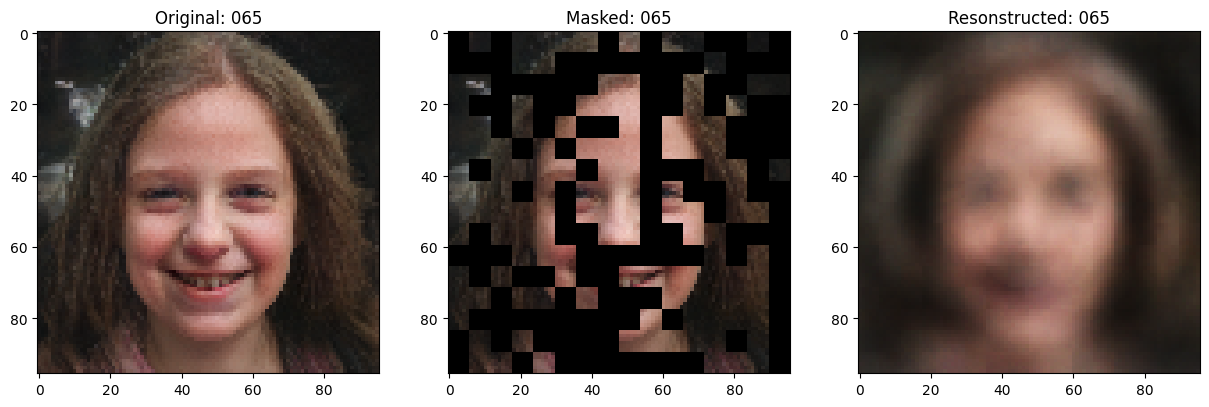

33/33 [==============================] - 24s 741ms/step - loss: 0.0106 - mae: 0.0731 - val_loss: 0.0147 - val_mae: 0.0846
Epoch 67/100
33/33 [==============================] - 24s 714ms/step - loss: 0.0105 - mae: 0.0728 - val_loss: 0.0145 - val_mae: 0.0843
Epoch 68/100
33/33 [==============================] - 24s 725ms/step - loss: 0.0105 - mae: 0.0727 - val_loss: 0.0146 - val_mae: 0.0844
Epoch 69/100
33/33 [==============================] - 23s 710ms/step - loss: 0.0104 - mae: 0.0724 - val_loss: 0.0145 - val_mae: 0.0842
Epoch 70/100
33/33 [==============================] - 24s 725ms/step - loss: 0.0105 - mae: 0.0725 - val_loss: 0.0145 - val_mae: 0.0840
Epoch 71/100
33/33 [==============================] - ETA: 0s - loss: 0.0104 - mae: 0.0721
Idx chosen: 234


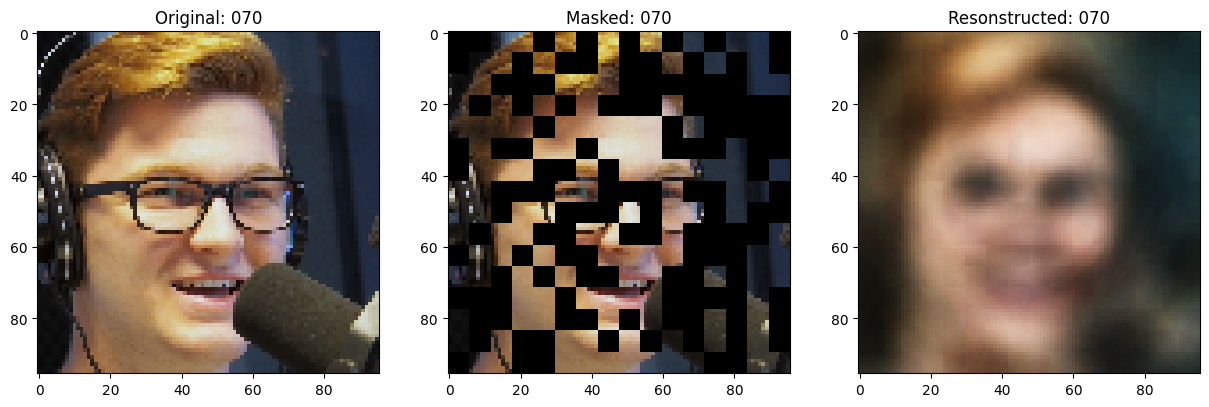

33/33 [==============================] - 24s 738ms/step - loss: 0.0104 - mae: 0.0721 - val_loss: 0.0144 - val_mae: 0.0837
Epoch 72/100
33/33 [==============================] - 24s 745ms/step - loss: 0.0104 - mae: 0.0721 - val_loss: 0.0144 - val_mae: 0.0838
Epoch 73/100
33/33 [==============================] - 23s 713ms/step - loss: 0.0104 - mae: 0.0719 - val_loss: 0.0142 - val_mae: 0.0833
Epoch 74/100
33/33 [==============================] - 23s 712ms/step - loss: 0.0103 - mae: 0.0716 - val_loss: 0.0143 - val_mae: 0.0834
Epoch 75/100
33/33 [==============================] - 24s 734ms/step - loss: 0.0103 - mae: 0.0716 - val_loss: 0.0143 - val_mae: 0.0830
Epoch 76/100
33/33 [==============================] - ETA: 0s - loss: 0.0102 - mae: 0.0712
Idx chosen: 65


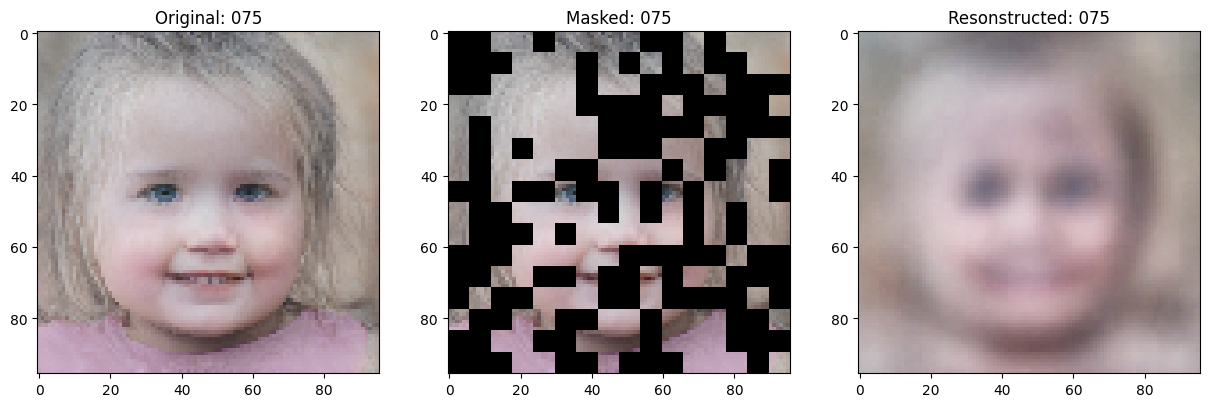

33/33 [==============================] - 25s 756ms/step - loss: 0.0102 - mae: 0.0712 - val_loss: 0.0142 - val_mae: 0.0828
Epoch 77/100
33/33 [==============================] - 24s 723ms/step - loss: 0.0102 - mae: 0.0712 - val_loss: 0.0142 - val_mae: 0.0830
Epoch 78/100
33/33 [==============================] - 23s 713ms/step - loss: 0.0101 - mae: 0.0710 - val_loss: 0.0142 - val_mae: 0.0828
Epoch 79/100
33/33 [==============================] - 24s 733ms/step - loss: 0.0101 - mae: 0.0709 - val_loss: 0.0142 - val_mae: 0.0827
Epoch 80/100
33/33 [==============================] - 24s 736ms/step - loss: 0.0101 - mae: 0.0708 - val_loss: 0.0142 - val_mae: 0.0827
Epoch 81/100
33/33 [==============================] - ETA: 0s - loss: 0.0101 - mae: 0.0706
Idx chosen: 7


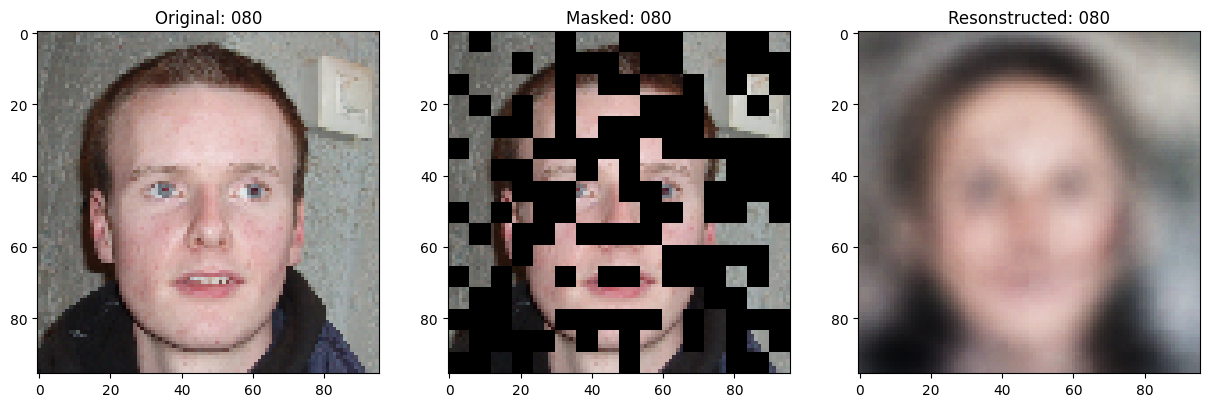

33/33 [==============================] - 25s 761ms/step - loss: 0.0101 - mae: 0.0706 - val_loss: 0.0141 - val_mae: 0.0823
Epoch 82/100
33/33 [==============================] - 23s 711ms/step - loss: 0.0100 - mae: 0.0705 - val_loss: 0.0141 - val_mae: 0.0823
Epoch 83/100
33/33 [==============================] - 23s 710ms/step - loss: 0.0100 - mae: 0.0703 - val_loss: 0.0141 - val_mae: 0.0822
Epoch 84/100
33/33 [==============================] - 23s 712ms/step - loss: 0.0100 - mae: 0.0703 - val_loss: 0.0141 - val_mae: 0.0823
Epoch 85/100
33/33 [==============================] - 24s 737ms/step - loss: 0.0100 - mae: 0.0703 - val_loss: 0.0141 - val_mae: 0.0820
Epoch 86/100
33/33 [==============================] - ETA: 0s - loss: 0.0099 - mae: 0.0701
Idx chosen: 254


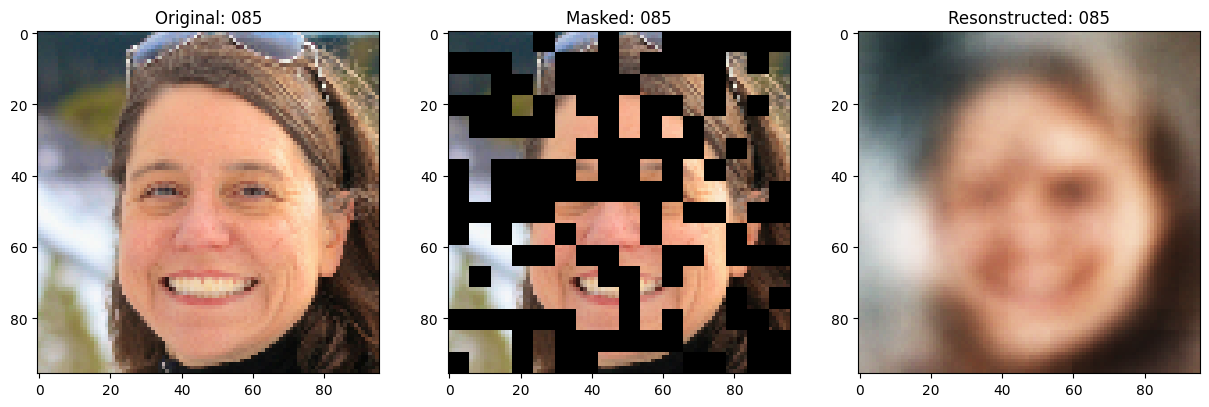

33/33 [==============================] - 25s 755ms/step - loss: 0.0099 - mae: 0.0701 - val_loss: 0.0139 - val_mae: 0.0818
Epoch 87/100
33/33 [==============================] - 24s 736ms/step - loss: 0.0099 - mae: 0.0700 - val_loss: 0.0140 - val_mae: 0.0820
Epoch 88/100
33/33 [==============================] - 24s 738ms/step - loss: 0.0099 - mae: 0.0699 - val_loss: 0.0140 - val_mae: 0.0818
Epoch 89/100
33/33 [==============================] - 24s 718ms/step - loss: 0.0099 - mae: 0.0699 - val_loss: 0.0140 - val_mae: 0.0818
Epoch 90/100
33/33 [==============================] - 24s 714ms/step - loss: 0.0099 - mae: 0.0699 - val_loss: 0.0140 - val_mae: 0.0818
Epoch 91/100
33/33 [==============================] - ETA: 0s - loss: 0.0099 - mae: 0.0698
Idx chosen: 41


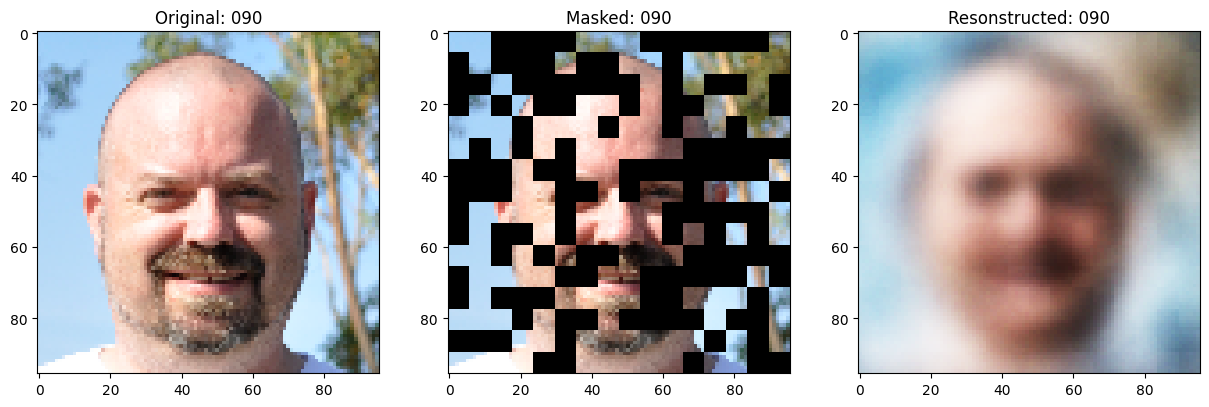

33/33 [==============================] - 26s 784ms/step - loss: 0.0099 - mae: 0.0698 - val_loss: 0.0139 - val_mae: 0.0816
Epoch 92/100
33/33 [==============================] - 24s 739ms/step - loss: 0.0099 - mae: 0.0700 - val_loss: 0.0139 - val_mae: 0.0816
Epoch 93/100
33/33 [==============================] - 23s 711ms/step - loss: 0.0099 - mae: 0.0700 - val_loss: 0.0139 - val_mae: 0.0818
Epoch 94/100
33/33 [==============================] - 24s 725ms/step - loss: 0.0099 - mae: 0.0698 - val_loss: 0.0139 - val_mae: 0.0817
Epoch 95/100
33/33 [==============================] - 24s 713ms/step - loss: 0.0099 - mae: 0.0699 - val_loss: 0.0139 - val_mae: 0.0817
Epoch 96/100
33/33 [==============================] - ETA: 0s - loss: 0.0099 - mae: 0.0698
Idx chosen: 31


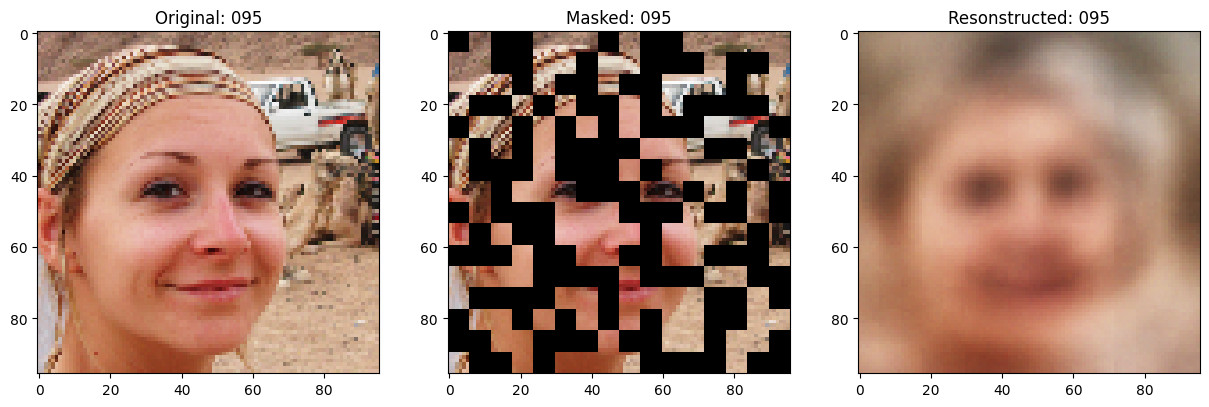

33/33 [==============================] - 25s 770ms/step - loss: 0.0099 - mae: 0.0698 - val_loss: 0.0139 - val_mae: 0.0818
Epoch 97/100
33/33 [==============================] - 24s 719ms/step - loss: 0.0098 - mae: 0.0697 - val_loss: 0.0139 - val_mae: 0.0817
Epoch 98/100
33/33 [==============================] - 23s 710ms/step - loss: 0.0100 - mae: 0.0701 - val_loss: 0.0140 - val_mae: 0.0820
Epoch 99/100
33/33 [==============================] - 23s 712ms/step - loss: 0.0099 - mae: 0.0701 - val_loss: 0.0140 - val_mae: 0.0821
Epoch 100/100
5/5 [==============================] - 1s 190ms/step - loss: 0.0138 - mae: 0.0816
Loss: 0.01
MAE: 0.08


In [17]:
optimizer = tfa.optimizers.AdamW(learning_rate=scheduled_lrs, weight_decay=WEIGHT_DECAY)

# Compile and pretrain the model.
mae_model.compile(
    optimizer=optimizer, loss=keras.losses.MeanSquaredError(), metrics=["mae"]
)
history = mae_model.fit(
    train_ds, epochs=EPOCHS, validation_data=val_ds, callbacks=train_callbacks,
)

# Measure its performance.
loss, mae = mae_model.evaluate(test_ds)
print(f"Loss: {loss:.2f}")
print(f"MAE: {mae:.2f}")

**Use encoder for classification Task**

In [18]:
# Extract the augmentation layers.
train_augmentation_model = mae_model.train_augmentation_model
test_augmentation_model = mae_model.test_augmentation_model

# Extract the patchers.
patch_layer = mae_model.patch_layer
patch_encoder = mae_model.patch_encoder
patch_encoder.downstream = True  # Swtich the downstream flag to True.

# Extract the encoder.
encoder = mae_model.encoder

# Pack as a model.
downstream_model = keras.Sequential(
    [
        layers.Input((IMAGE_SIZE, IMAGE_SIZE, 3)),
        patch_layer,
        patch_encoder,
        encoder,
        layers.BatchNormalization(),  # Refer to A.1 (Linear probing).
        layers.GlobalAveragePooling1D(),
        layers.Dense(NUM_CLASSES, activation="softmax"),
    ],
    name="classification",
)

# Only the final classification layer of the `downstream_model` should be trainable.
for layer in downstream_model.layers[:-1]:
    layer.trainable = False

downstream_model.summary()

Model: "classification"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patches (Patches)           (None, 256, 108)          0         
                                                                 
 patch_encoder (PatchEncoder  (None, 256, 128)         14060     
 )                                                               
                                                                 
 mae_encoder (Functional)    (None, None, 128)         795136    
                                                                 
 batch_normalization (BatchN  (None, 256, 128)         512       
 ormalization)                                                   
                                                                 
 global_average_pooling1d (G  (None, 128)              0         
 lobalAveragePooling1D)                                          
                                                    

In [22]:
mae_model.save_weights('/content/drive/MyDrive/project2VDT/sourceCode/H.Phú/MAE_50/MAE_50')

In [20]:
def prepare_data(images, labels, is_train=True):
    if is_train:
        augmentation_model = train_augmentation_model
    else:
        augmentation_model = test_augmentation_model

    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if is_train:
        dataset = dataset.shuffle(BUFFER_SIZE)

    dataset = dataset.batch(BATCH_SIZE).map(
        lambda x, y: (augmentation_model(x), y), num_parallel_calls=AUTO
    )
    return dataset.prefetch(AUTO)


train_ds = prepare_data(x_train, y_train)
val_ds = prepare_data(x_val, y_val, is_train=False)
test_ds = prepare_data(x_test, y_test, is_train=False)

In [21]:
linear_probe_epochs = 100
linear_prob_lr = 0.1
warm_epoch_percentage = 0.1
steps = int((len(x_train) // BATCH_SIZE) * linear_probe_epochs)

warmup_steps = int(steps * warm_epoch_percentage)
scheduled_lrs = WarmUpCosine(
    learning_rate_base=linear_prob_lr,
    total_steps=steps,
    warmup_learning_rate=0.0,
    warmup_steps=warmup_steps,
)

optimizer = keras.optimizers.SGD(learning_rate=scheduled_lrs, momentum=0.9)
downstream_model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy", tfa.metrics.F1Score(num_classes=2)]
)

# earlystopping_cb = keras.callbacks.EarlyStopping(monitor="f1_score", patience = 20)
history = downstream_model.fit(train_ds, validation_data=val_ds, epochs=linear_probe_epochs)

loss, accuracy, f1_score_res = downstream_model.evaluate(test_ds)
accuracy = round(accuracy * 100, 2)
print(f"Accuracy on the test set: {accuracy}%.")
print("f1_score: ", f1_score_res)

Epoch 1/100
33/33 [==============================] - 26s 378ms/step - loss: 0.7523 - accuracy: 0.5884 - f1_score: 0.5628 - val_loss: 1.4618 - val_accuracy: 0.4190 - val_f1_score: 0.3006
Epoch 2/100
33/33 [==============================] - 13s 375ms/step - loss: 1.3452 - accuracy: 0.5295 - f1_score: 0.5184 - val_loss: 2.8577 - val_accuracy: 0.4236 - val_f1_score: 0.3094
Epoch 3/100
33/33 [==============================] - 12s 347ms/step - loss: 2.3323 - accuracy: 0.5300 - f1_score: 0.5167 - val_loss: 3.9940 - val_accuracy: 0.4477 - val_f1_score: 0.3540
Epoch 4/100
33/33 [==============================] - 13s 395ms/step - loss: 3.4427 - accuracy: 0.5284 - f1_score: 0.5149 - val_loss: 5.0757 - val_accuracy: 0.4710 - val_f1_score: 0.3939
Epoch 5/100
33/33 [==============================] - 12s 343ms/step - loss: 4.4616 - accuracy: 0.5270 - f1_score: 0.5144 - val_loss: 5.7565 - val_accuracy: 0.4998 - val_f1_score: 0.4402
Epoch 6/100
33/33 [==============================] - 13s 387ms/step - 

In [25]:
downstream_model.save_weights('/content/drive/MyDrive/project2VDT/sourceCode/H.Phú/CLASSIFICATION_MAE_50/CLASSIFICATION_MAE_50')

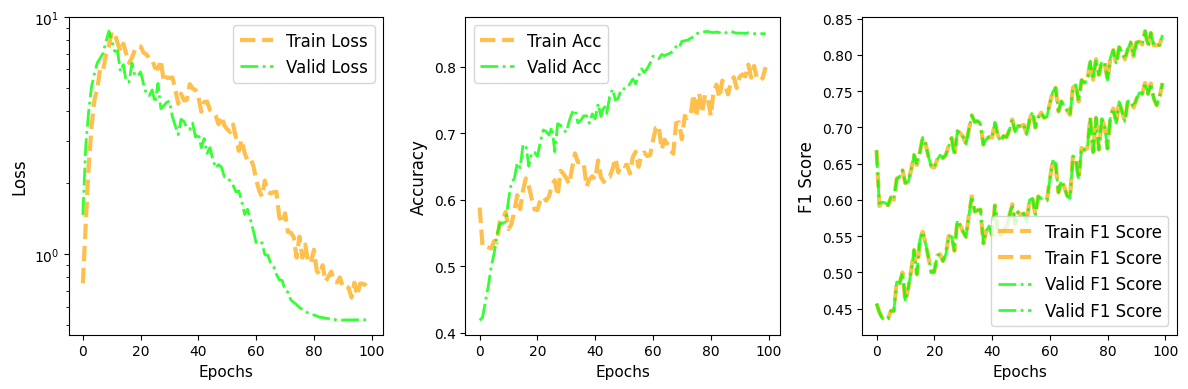

In [23]:
### Plot train and validation curves
history = history.history
loss = history['loss']
v_loss = history['val_loss']

acc = history['accuracy'] 
v_acc = history['val_accuracy']

f1_score = history['f1_score']
val_f1_score = history['f1_score']
epochs = range(len(loss))

fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 3, 1)
plt.yscale('log')
plt.plot(epochs, loss, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Loss')
plt.plot(epochs, v_loss, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Loss')
# plt.ylim(0.3, 100)
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Loss', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 2)
plt.plot(epochs, acc, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train Acc')
plt.plot(epochs, v_acc, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid Acc') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(fontsize=12)
plt.subplot(1, 3, 3)
plt.plot(epochs, f1_score, linestyle='--', linewidth=3, color='orange', alpha=0.7, label='Train F1 Score')
plt.plot(epochs, val_f1_score, linestyle='-.', linewidth=2, color='lime', alpha=0.8, label='Valid F1 Score') 
plt.xlabel('Epochs', fontsize=11)
plt.ylabel('F1 Score', fontsize=12)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()